In [1]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from urllib.parse import urlparse
import os
import numpy as np
from IPython.display import clear_output, display
import time
import pandas as pd

from Constants import Constants, specialTokenList, specialTokens
from All_Models import SSCL, GatedCNN, SelfAttnModel
from utils import getSampler
from Trainers import Trainer
from LoadData import loadingData


%matplotlib inline

'''
TODO:

1. Try Larger Vocab size
4. Do Tkinter


'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class args(object):

    # Data
    
    
    dataset = ["HSpam14", "Honeypot"][0]
    full_data = True
    usingWeightRandomSampling = True
    vocab_size = 8000 # if we create the new vocab size, we have to do the new preprocess again
    validation_portion = 0.05
    test_portion = 0.04
    random_seed = 64
    
    pickle_name = "FullPickleData"+ str(vocab_size) + "Vocab.txt"
    pickle_name_beforeMapToIdx = "FullPickleDatabeforeMapToIdx.txt"


    ##### Arch

    ## GatedCNN arch

    GatedCNN_embedingDim = 128
    GatedCNN_convDim = 64
    GatedCNN_kernel = 3
    GatedCNN_stride = 1
    GatedCNN_pad = 1
    GatedCNN_layers = 8
    GatedCNN_dropout = 0.1
        
    ## SSCL arch
    
    
    SSCL_embedingDim = 512
    SSCL_RNNHidden = 256
    SSCL_CNNDim = 256
    SSCL_CNNKernel = 5
    SSCL_CNNDropout = 0.1
    SSCL_LSTMDropout = 0.1
    SSCL_LSTMLayers = 1
    
    ## Attn arch

    SelfAttn_LenMaxSeq = 280 # Default, will be changed Later

    # These Two has to be the same
    SelfAttn_WordVecDim = 128
    SelfAttn_ModelDim = 128
    
    SelfAttn_FFInnerDim = 256
    SelfAttn_NumLayers = 3
    SelfAttn_NumHead = 4
    SelfAttn_KDim = 64
    SelfAttn_VDim = 64
    SelfAttn_Dropout = 0.1
    
    # Training params
    
    batch_size = 64
    L2 = 0.1
    threshold = 0.5
    lr = 0.002
    n_epoch = 50

    # If using Adam
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    
    earlyStopStep = 50000 # Set None if we don't want it
    earlyStopEpoch = 1 #

    # Logging the Training
    val_freq = 50
    val_steps = 3
    log_freq = 10
    model_save_freq = 1
    model_name = 'GatedCNN_Vocab8000_RandomWeightedSampling_WithDropout'
    model_path = './'+ dataset +'_Log/' + model_name + '/Model/'
    log_path = './' + dataset +'_Log/' + model_name + '/Log/'

args.device = device

# Create the path for saving model and the log
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

if not os.path.exists(args.log_path):
    os.makedirs(args.log_path)

In [2]:
training_dataset, validation_dataset, test_dataset, text = loadingData(args)

Loading Existing File:  FullPickleData8000Vocab.txt


In [3]:
# Put it after the training set
args.numberOfSpammer = sum([t[-1] for t in training_dataset])
args.numberOfNonSpammer = len(training_dataset)-args.numberOfSpammer
args.len_max_seq = training_dataset[0][2]

print("Number of Spammer: ", args.numberOfSpammer)
print("Number of NonSpammer: ", args.numberOfNonSpammer)

Number of Spammer:  tensor(193002.)
Number of NonSpammer:  tensor(894927.)


In [4]:
if args.usingWeightRandomSampling:
    sampler = getSampler(training_dataset)
else:
    sampler = None

train_loader = DataLoader(
    training_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False, sampler = sampler)
valid_loader = DataLoader(
    validation_dataset, batch_size=args.batch_size, shuffle=True, drop_last=False)

trainer = Trainer(GatedCNN, args).to(device)

print("Number of Parameters in this Model: ",trainer.num_all_params())
print("Using device: ", device)

scheduler = optim.lr_scheduler.StepLR(trainer.optim, 2000, gamma=0.85)
# trainer.optim.param_groups[0]['lr']=
allStep = 0
epoch = 0

/home/chihcheng/python3env/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


Number of Parameters in this Model:  1273025
Using device:  cuda


In [5]:
print("Model Structure: \n", trainer.model)

Model Structure: 
 GatedCNN(
  (emb): Embedding(8000, 128)
  (conv): ModuleList(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
      (3): Dropout(p=0.1)
    )
    (2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
      (3): Dropout(p=0.1)
    )
    (3): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
      (3): Dropout(p=0.1)
    )
    (4): Sequential(
      (0): Conv1d(64, 64, kernel_

TrainConfusion Matrix: 



,0,1
0,36,1
1,7,20


ValConfusion Matrix: 



,0,1
0,50,2
1,3,9


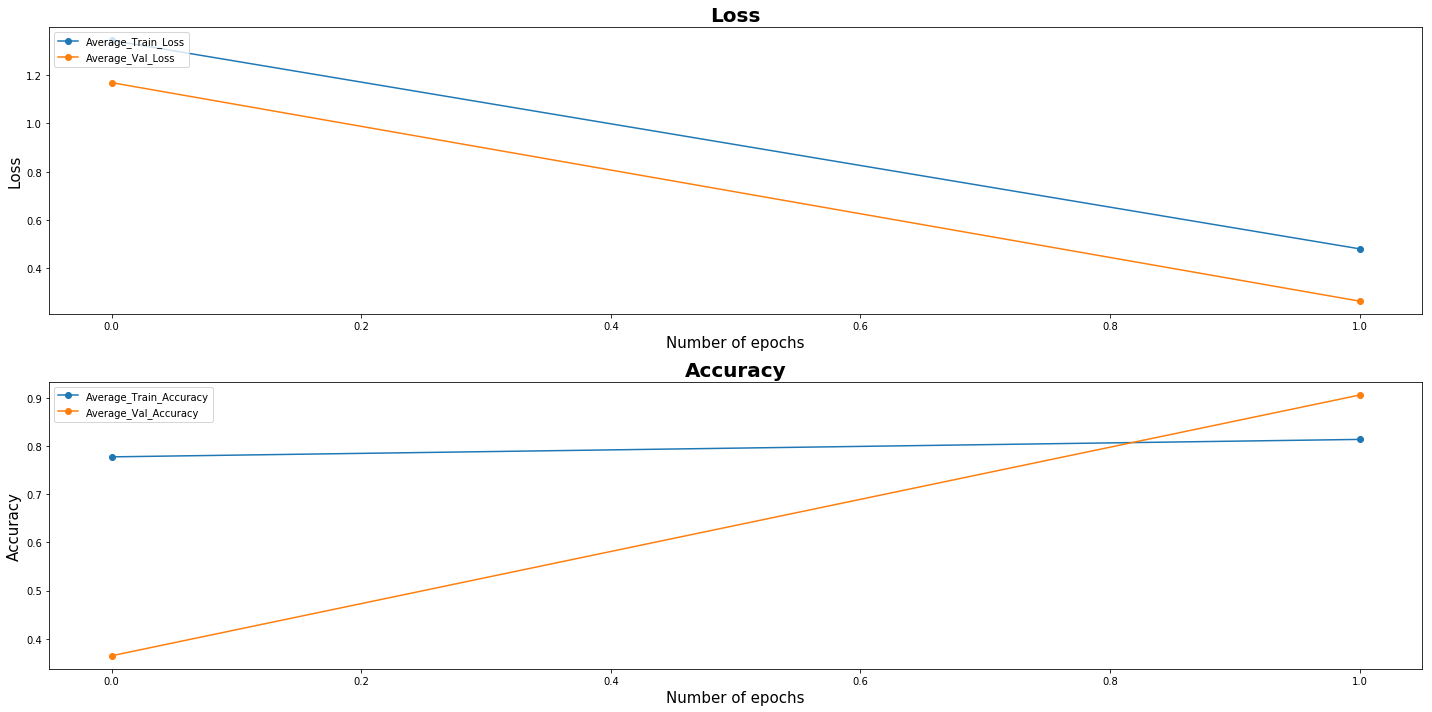

| Epoch [0] | Step [101] | lr [0.002000] | Loss: [0.4593] | Acc: [0.8281] | Time: 0.0s
| Epoch [0] | Step [102] | lr [0.002000] | Loss: [0.4009] | Acc: [0.8750] | Time: 0.0s
| Epoch [0] | Step [103] | lr [0.002000] | Loss: [0.4881] | Acc: [0.7812] | Time: 0.0s
| Epoch [0] | Step [104] | lr [0.002000] | Loss: [0.4027] | Acc: [0.8750] | Time: 0.0s
| Epoch [0] | Step [105] | lr [0.002000] | Loss: [0.4600] | Acc: [0.7344] | Time: 0.0s
| Epoch [0] | Step [106] | lr [0.002000] | Loss: [0.4497] | Acc: [0.7344] | Time: 0.0s
| Epoch [0] | Step [107] | lr [0.002000] | Loss: [0.3221] | Acc: [0.8906] | Time: 0.0s
| Epoch [0] | Step [108] | lr [0.002000] | Loss: [0.3479] | Acc: [0.8281] | Time: 0.0s
| Epoch [0] | Step [109] | lr [0.002000] | Loss: [0.3223] | Acc: [0.8438] | Time: 0.0s
| Epoch [0] | Step [110] | lr [0.002000] | Loss: [0.3540] | Acc: [0.8594] | Time: 0.0s


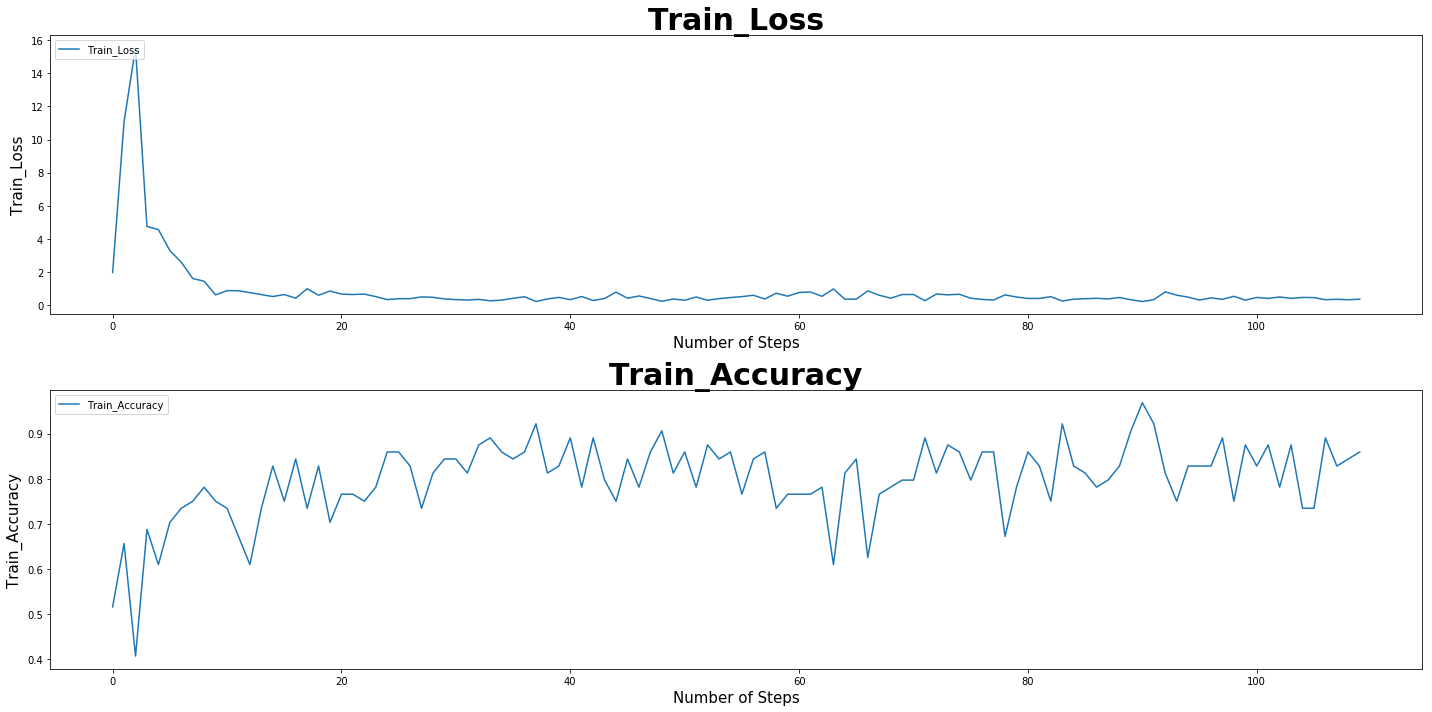

| Epoch [0] | Step [111] | lr [0.002000] | Loss: [0.3489] | Acc: [0.8281] | Time: 0.0s
| Epoch [0] | Step [112] | lr [0.002000] | Loss: [0.3836] | Acc: [0.8125] | Time: 0.0s
| Epoch [0] | Step [113] | lr [0.002000] | Loss: [0.5564] | Acc: [0.7344] | Time: 0.0s
| Epoch [0] | Step [114] | lr [0.002000] | Loss: [0.5195] | Acc: [0.7500] | Time: 0.0s
| Epoch [0] | Step [115] | lr [0.002000] | Loss: [0.2988] | Acc: [0.8594] | Time: 0.0s
| Epoch [0] | Step [116] | lr [0.002000] | Loss: [0.3643] | Acc: [0.8594] | Time: 0.0s
| Epoch [0] | Step [117] | lr [0.002000] | Loss: [0.3486] | Acc: [0.8906] | Time: 0.0s
| Epoch [0] | Step [118] | lr [0.002000] | Loss: [0.3744] | Acc: [0.8438] | Time: 0.0s
| Epoch [0] | Step [119] | lr [0.002000] | Loss: [0.5998] | Acc: [0.7812] | Time: 0.0s
| Epoch [0] | Step [120] | lr [0.002000] | Loss: [0.3251] | Acc: [0.8906] | Time: 0.0s


KeyboardInterrupt: 

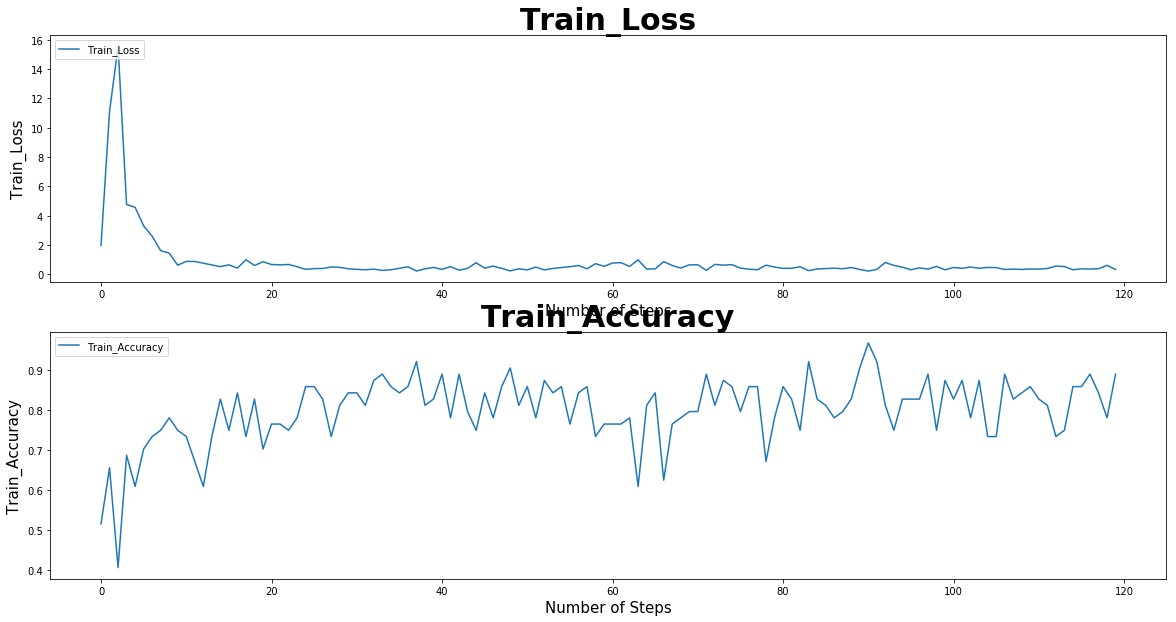

In [6]:
while epoch < args.n_epoch:
    for i, (texts, X , X_len, y) in enumerate(train_loader):
        
        trainer.train()
        X, X_len, y = X.to(device), X_len.to(device), y.to(device)
        
        if trainer.optim.param_groups[0]['lr'] >= 0.00001:
            scheduler.step()
        start_t = time.time()
#         trainer.train_step((X, X_len), y)
        trainer.train_step(X, y)

        end_t = time.time()
        allStep += 1
        print('| Epoch [%d] | Step [%d] | lr [%.6f] | Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %
              (epoch, allStep, trainer.optim.param_groups[0]['lr'], trainer.loss.item(), trainer.accuracy.item(),
               end_t - start_t))

#         if trainer.accuracy.item() > 0.95: # Stop early
#             raise StopIteration
        if allStep % args.log_freq == 0:
            trainer.plot_train_hist(args.model_name)
            
        
        if args.earlyStopStep:
            if allStep >= args.earlyStopStep:
                    raise StopIteration
        

        if allStep % args.val_freq == 0:

            for _ in range(args.val_steps):
                trainer.eval()
                stIdx = np.random.randint(
                    0, len(validation_dataset) - args.batch_size)
                v_text, v_X, v_X_len, v_y = validation_dataset[stIdx: stIdx +
                                                       args.batch_size]
                v_X, v_X_len, v_y = v_X.to(
                    device), v_X_len.to(device), v_y.to(device)
                start_t = time.time()
#                 trainer.test_step((v_X, v_X_len), v_y)
                trainer.test_step(v_X, v_y)
                end_t = time.time()
                print('| Epoch [%d] | Validation | Step [%d] |  Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %
                      (epoch, allStep, trainer.loss.item(), trainer.accuracy.item(), end_t - start_t))
            trainer.calculateAverage()
            clear_output()
            print("TrainConfusion Matrix: \n")
            display(pd.DataFrame(trainer.cms['Train'][-1]))
            print("ValConfusion Matrix: \n")
            display(pd.DataFrame(trainer.cms['Val'][-1]))
            trainer.plot_all(args.model_name)
            
            
            
     # After every Epoch, if can be moved

    epoch += 1
    trainer.model_save(epoch)


    if args.earlyStopEpoch:
        if epoch >= args.earlyStopEpoch:
            raise StopIteration5000


In [7]:
test_text, test_X, test_X_len, test_y  =  zip(test_dataset[0:])
test_text, test_X, test_X_len, test_y = test_text[0], test_X[0].to(device), test_X_len[0].to(device), test_y[0].to(device)

test_loss, test_accuracy, test_cm = trainer.test_step(test_X, test_y)

print("The Test Loss: ", test_loss.item())
print("The Test Accuracy: ", test_accuracy.item())
print("Test Confusion Matrix: \n", test_cm)

## Need Dropout

The Test Loss:  0.7476904988288879
The Test Accuracy:  0.6730685234069824
Test Confusion Matrix: 
 [[1160  725]
 [  24  382]]
